# Домашнее задание № 2

## по дисциплине: Машинное обучение в бизнесе

### выполнил: Евгений Кириллов

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 4 разных методов получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [1]:
# !pip install gensim
# !pip install razdel
# !pip install pymorphy2
# !pip install nltk

In [2]:
import pandas as pd
import numpy as np

import re
import nltk  # required to download stopwords - nltk.download('stopwords')
import pymorphy2  # required for normalization of words

from nltk.corpus import stopwords  # required to upload stopwords
from gensim.corpora.dictionary import Dictionary  # required to create dictionary
from razdel import tokenize  # required to tokenize a text - transform them into a list of words

### uploading dataframe of articles

In [3]:
news = pd.read_csv("lesson_2_profiling_user_LDA/materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


### uploading dataframe of users

In [4]:
users = pd.read_csv("lesson_2_profiling_user_LDA/users_articles.csv")
print(users.shape)
users.head(3)

(8000, 2)


,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


## PART 1 - Vectors of Articles

### downloading stopwords

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fross\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
stopword_ru = stopwords.words('russian')
print(stopword_ru[:10])
print(len(stopword_ru))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']
151


### adding additional stopwards from file

In [7]:
with open('lesson_2_profiling_user_LDA/stopwords_additional_russian.txt', encoding="utf8") as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
print(stopword_ru[-10:])
len(stopword_ru)

['сообщает_риа_"новости"', 'передает_риа_"новости"', 'понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье', 'сообщил_журналист']


415

### function to clean a text from special symbols

In [8]:
def clean_text(text):
    '''
    очистка текста
    на выходе очищеный текст
    '''
    
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^'•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    return text

#### demostration of how 'clean_text' works

In [9]:
clean_text('\n-I like 44 *pineapples!-')

C:\Users\fross\AppData\Local\Temp/ipykernel_4596/813516641.py:14: FutureWarning: Possible nested set at position 40
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^'•·&()]|[+=]|[[]|[]]|[/]|", '', text)


'i like  pineapples'

### function to transform a text into tokenized list of words in their normal form

In [10]:
cache = {}
morph = pymorphy2.MorphAnalyzer()
def lemmatization(text):
    '''
    the function is required to transform a text/article into a list of words in their normal form
        [0] changing of type to `str` if not `str`
        [1] tokenization with razdel
        [2] checking whether a word starts with '-'
        [3] checking whether there is more than one symbol in a word
        [4] checking whether a word is in cashe
        [5] lemmatization of word - bringing it into its normal form
        [6] throwing out stopwords from final list of words
    '''
    
    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

#### demonstration of how pymorphy2.MorphAnalyzer().parse('...') works

In [11]:
pymorphy2.MorphAnalyzer().parse('играл')

[Parse(word='играл', tag=OpencorporaTag('VERB,impf,tran masc,sing,past,indc'), normal_form='играть', score=1.0, methods_stack=((DictionaryAnalyzer(), 'играл', 1694, 7),))]

In [12]:
pymorphy2.MorphAnalyzer().parse('играл')[0].normal_form

'играть'

#### demonstration of how 'tokenize' (razdel.tokenize) works

In [13]:
[_ for _ in tokenize('Мама мыла раму')]

[Substring(0, 4, 'Мама'), Substring(5, 9, 'мыла'), Substring(10, 14, 'раму')]

In [14]:
[_.text for _ in tokenize('Мама мыла раму')]

['Мама', 'мыла', 'раму']

#### demonstration of how 'lemmatization' works

In [15]:
lemmatization('Мама мыла раму')

['мама', 'мыло', 'рама']

### let's start 'clean_text', it is going to take some time...

In [16]:
print(news['title'][88])  # before

Футбольный клуб «Анжи» объявил об усилении тренерского штаба команды, об этом сообщаетnофициальный сайтnмахачкалинцев.nПомогать главному тренеру, Гусу Хиддинку, в тренировочном процессе призваны бывший сотрудник «Манчестер Юнайтед» Рене Меленстен (бывший помощник Алекса Фергюсона) и Хасанби Биджиев.nОба тренера имеют тренерскую категорию PRO. При этом Биджиев продолжит исполнение функций спортивного директора нашего клуба.nВ свою очередь медицинское подразделение штаба пополнят такие специалисты как массажист-терапевт Денни Флиттер (Великобритания, «Арсенал» Лондон), физиотерапевт Доминик Роган (Великобритания, «Эвертон»), тренер по физической подготовке Эдуардо Парра Гарсия (Испания, «Интер» Милан, «Ливерпуль»), специалист по спортивной науке Уорд Дирикс (Бельгия, «Гент»), массажист-терапевт Уильям Стори (Великобритания, «Вест Хэм») и тренер по физподготовке Брэм Суиннинен (Бельгия, БК «Химки»).


In [17]:
%%time
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 22.4 s


In [18]:
print(news['title'][88])  # after

футбольный клуб анжи объявил об усилении тренерского штаба команды об этом сообщаетnофициальный сайтnмахачкалинцевnпомогать главному тренеру гусу хиддинку в тренировочном процессе призваны бывший сотрудник манчестер юнайтед рене меленстен бывший помощник алекса фергюсона и хасанби биджиевnоба тренера имеют тренерскую категорию pro при этом биджиев продолжит исполнение функций спортивного директора нашего клубаnв свою очередь медицинское подразделение штаба пополнят такие специалисты как массажисттерапевт денни флиттер великобритания арсенал лондон физиотерапевт доминик роган великобритания эвертон тренер по физической подготовке эдуардо парра гарсия испания интер милан ливерпуль специалист по спортивной науке уорд дирикс бельгия гент массажисттерапевт уильям стори великобритания вест хэм и тренер по физподготовке брэм суиннинен бельгия бк химки


### let's start 'lemmatization', it is going to take long time...

In [19]:
print(news['title'][88])  # before

футбольный клуб анжи объявил об усилении тренерского штаба команды об этом сообщаетnофициальный сайтnмахачкалинцевnпомогать главному тренеру гусу хиддинку в тренировочном процессе призваны бывший сотрудник манчестер юнайтед рене меленстен бывший помощник алекса фергюсона и хасанби биджиевnоба тренера имеют тренерскую категорию pro при этом биджиев продолжит исполнение функций спортивного директора нашего клубаnв свою очередь медицинское подразделение штаба пополнят такие специалисты как массажисттерапевт денни флиттер великобритания арсенал лондон физиотерапевт доминик роган великобритания эвертон тренер по физической подготовке эдуардо парра гарсия испания интер милан ливерпуль специалист по спортивной науке уорд дирикс бельгия гент массажисттерапевт уильям стори великобритания вест хэм и тренер по физподготовке брэм суиннинен бельгия бк химки


In [20]:
%%time
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 2min 31s


In [21]:
print(news['title'][88])  # after

['футбольный', 'клуб', 'анжи', 'объявить', 'усиление', 'тренерский', 'штаб', 'команда', 'официальный', 'сайт', 'махачкалинец', 'помогать', 'главный', 'тренер', 'гуса', 'хиддинк', 'тренировочный', 'процесс', 'призвать', 'бывший', 'сотрудник', 'манчестер', 'юнайтед', 'рен', 'меленстен', 'бывший', 'помощник', 'алекс', 'фергюсон', 'хасанби', 'биджиев', 'оба', 'тренер', 'иметь', 'тренерский', 'категория', 'pro', 'биджиев', 'продолжить', 'исполнение', 'функция', 'спортивный', 'директор', 'клуб', 'очередь', 'медицинский', 'подразделение', 'штаб', 'пополнить', 'специалист', 'массажисттерапевт', 'денни', 'флиттереть', 'великобритания', 'арсенал', 'лондон', 'физиотерапевт', 'доминик', 'рогать', 'великобритания', 'эвертон', 'тренер', 'физический', 'подготовка', 'эдуардо', 'парра', 'гарсия', 'испания', 'интер', 'милан', 'ливерпуль', 'специалист', 'спортивный', 'наука', 'уорд', 'дирикс', 'бельгия', 'гент', 'массажисттерапевт', 'уильям', 'стори', 'великобритания', 'вест', 'хэм', 'тренер', 'физподгот

### let's create corpus - a list of 'bag of words' sparse matrixes, each of which corresponds to a news

In [22]:
# creation of list of texts (texts are lists of cleanded and lemmatized words)
texts = [_ for _ in news['title'].values]  # 'texts' is to be a list of lists of tokenized and lemmatized words

# creation of a corpus from a list of texts
common_dictionary = Dictionary(texts)  # creation of 'common_dictionary' - the list of all words in all documents;
                                       # words are normalized and stopwords are not included
common_corpus = [common_dictionary.doc2bow(_) for _ in texts]  # creation of 'common_corpus' - the list of all texts;
                                                                     # texts are in form of 'bag of words' sparse matrix

In [23]:
print(common_dictionary[2], '\n')
print(common_dictionary[110111], '\n')
print(len(common_dictionary), '\n')

print(common_corpus[1], '\n')  # article#1 in form of bag of words' sparse matrix
print(len(common_corpus), news['title'].shape[0])

алексей 

эсенбог 

141570 

[(92, 2), (93, 1), (94, 1), (95, 1), (96, 1), (97, 2), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 3), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1), (111, 1), (112, 1), (113, 3), (114, 1), (115, 1), (116, 1), (117, 1), (118, 1), (119, 2), (120, 1), (121, 1), (122, 1), (123, 1), (124, 1)] 

27000 27000


### setting our main hyperparameter - number of topics

In [24]:
# N_topic = 25  # number of topics - hyperparameter; it can be tuned to improve performance
N_topic = 100  # number of topics - hyperparameter; it can be tuned to improve performance

### fitting our LdaModel

In [25]:
from gensim.models import LdaModel

In [26]:
%%time
lda = LdaModel(corpus=common_corpus,  # corpus param is fed with the list of all texts; texts are 'bag of words' sparse matrixes
               num_topics=N_topic,  # number of topics
               id2word=common_dictionary,  # id2word is fed with the dictionary of all words, so that the model may
                                           # convert incoming texts into words' ids and define topics' probabilities related
               passes=20)

Wall time: 30min


### saving and loading the model

In [27]:
# saving the model
# lda.save("model.lda")

# loading the model
# lda = LdaModel.load("model.lda")

#### demonstration of what LdaModel does

In [28]:
# let's take first 10 tokenized texts/articles and presume that our lda-model hasn't seen them
other_texts = [t for t in news['title'].iloc[:10]]

# let's convert these 10 tokenized texts/articles into sparse matrixes with 'bag of words' method of our gensim Dictionary
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

print(other_texts[2], '\n')
print(other_corpus[2], '\n')

# let's put one of these sparse matrices into our LdaModel to get topics' probabilities
print(lda[other_corpus[2]])

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший'] 

[(48, 1), (100, 1), (104, 2), (105, 1), (116, 1), (125, 1), (126, 1), (127, 1), (128, 1), (129, 1), (130, 1), (131, 1), (132, 1), (133, 2), (134, 1), (135, 1), (136, 1), (137, 1), (138, 1), (139, 1), (140, 1), (141, 1), (142, 1), (143, 1), (144, 1), (145, 1), (146, 1), (147, 2), (148, 1), (149, 1), (150, 1), (151, 1), (152, 1), (153, 3), (154, 1)] 

[(2, 0.025903475), (3, 0.026739819), (8, 0.03323719), (18, 0.026491338), (33, 0.026469134), (37, 0.051790442), (38, 0.022446366), (41, 0.023510017), (51, 0.06901089), (55, 0.029821845), (56, 0.39609653), (57, 0.111

### let's describe each topic our LdaModel created with 7 words

In [29]:
x = lda.show_topics(num_topics=N_topic, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

for topic, words in topics_words:
    print(f'topic_{topic}: {" ".join(words)}')

topic_0: сотрудник область задержать расследование служба уголовный препарат
topic_1: рак письмо запустить берег написать дата левый
topic_2: сравнение упасть километр летать лететь лагерь мск
topic_3: форум немецкий предложение бизнес идея автор труд
topic_4: млн млрд тыс стоимость около сумма составлять
topic_5: восток фотография дальний твиттер латвия взлёт компенсировать
topic_6: газета ru центр всё часть управление станция
topic_7: школа океан пол кожа открыться итальянский отражать
topic_8: ракета испытание противник боевой старт первый цель
topic_9: индия азия греческий вероятно недостаточно калифорния сегмент
topic_10: палата живой елена екатерина регистрация ирина остаток
topic_11: день температура экипаж аэропорт двигатель москва скорость
topic_12: рынок большой развитие первый программа проблема последний
topic_13: проверка социальный влиять средний поведение административный форма
topic_14: миссия вклад традиционный характерный родиться орден офис
topic_15: день британский 

### function to to transform a tokenized text into array of topics' probabilities

In [30]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

#### demonstration of what get_lda_vector does

In [31]:
print(news['title'].values[1])

['матч', 'финал', 'кубок', 'россия', 'футбол', 'приостановить', 'судья', 'изз', 'взрыв', 'пиротехнический', 'снаряд', 'передавать', 'корреспондент', 'газета', 'ru', 'болельщик', 'выбросить', 'поле', 'петарда', 'судья', 'увести', 'команда', 'поле', 'подтрибунный', 'помещение', 'динамовец', 'уйти', 'торпедовец', 'остаться', 'кромка', 'поле', 'матч', 'остановить', 'пять', 'минута', 'газета', 'ru', 'вести', 'онлайнтрансляция', 'матч']


In [32]:
get_lda_vector(news['title'].values[1])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.57849669, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0226203 , 0.        ,
       0.        , 0.        , 0.05375262, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.31985891, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

### creation of documents' ids/topics' probabilities dataframe

In [33]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_90,topic_91,topic_92,topic_93,topic_94,topic_95,topic_96,topic_97,topic_98,topic_99
0,6,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,4896,0.0,0.0,0.0,0.000000,0.0,0.0,0.578553,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,4897,0.0,0.0,0.0,0.026703,0.0,0.0,0.000000,0.0,0.033212,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.052196,0.0,0.0,0.0
3,4898,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.02926,0.0,0.0,0.012924,0.0,0.000000,0.0,0.0,0.0
4,4899,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


## PART 2 - Vectors of Users

In [34]:
users.head(2)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"


In [35]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topic)]].values))

In [36]:
doc_dict[6]  # array of topics' probabilities for article#6

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01107474, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01069056,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0432457 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07843778, 0.02325208, 0.0104759 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.05922883,
       0.        , 0.        , 0.        , 0.        , 0.03284154,
       0.        , 0.        , 0.        , 0.        , 0.     

### function to get the mean probabilities of topics of articles a user read

In [37]:
def get_user_embedding(user_articles_list):
    '''
    The function receives a list of articles' ids a user read - '[323329, 321961, 324743, 323186, 324632, 474690]'.
    It converts it into a list. After this list is converted into an array of arrays of articles' probabilities.
    After, the array of arrays is transformed into the array of mean values of probabilities.
    '''
    user_articles_list = eval(user_articles_list)  # converting string into list
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])  # creation of array of arrays
    user_vector = np.mean(user_vector, axis=0)  # creation of array of collumns' means
    return user_vector

#### simplified demonstration of the process

In [38]:
array_1 = np.array([1, 2, 3])
array_2 = np.array([4, 5, 6])
resulting_array = np.array([array_1, array_2])
print(resulting_array)
print(np.mean(resulting_array, axis=0))

[[1 2 3]
 [4 5 6]]
[2.5 3.5 4.5]


#### demonstration of how get_user_embedding works

In [39]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [40]:
get_user_embedding(users['articles'].iloc[33])

array([0.01828771, 0.00400727, 0.        , 0.01254563, 0.        ,
       0.        , 0.00666731, 0.00200549, 0.01090309, 0.00166671,
       0.        , 0.00202212, 0.04058334, 0.        , 0.        ,
       0.0030554 , 0.        , 0.01037888, 0.01041013, 0.        ,
       0.00489919, 0.        , 0.01964557, 0.        , 0.00647497,
       0.0033169 , 0.02488346, 0.        , 0.02007472, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00361557,
       0.05195309, 0.02813194, 0.        , 0.        , 0.        ,
       0.        , 0.00501262, 0.03851996, 0.01238812, 0.        ,
       0.        , 0.        , 0.        , 0.02342273, 0.00496619,
       0.        , 0.        , 0.        , 0.        , 0.00204646,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00402803, 0.00314801, 0.01355019, 0.04342158, 0.04128985,
       0.00596231, 0.        , 0.        , 0.        , 0.        ,
       0.00276211, 0.00246003, 0.        , 0.03922434, 0.     

so, the result is user's vector

### creation of users' ids/mean topics' probabilities of articles read dataframe

In [41]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings.head(2)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_90,topic_91,topic_92,topic_93,topic_94,topic_95,topic_96,topic_97,topic_98,topic_99
0,u105138,0.000000,0.0,0.0,0.004999,0.022446,0.012564,0.044410,0.00443,0.019581,...,0.0,0.003972,0.004430,0.008595,0.004498,0.040726,0.000000,0.005747,0.026148,0.0
1,u108690,0.021884,0.0,0.0,0.000000,0.016836,0.002144,0.053757,0.00207,0.000000,...,0.0,0.000000,0.002071,0.000000,0.004578,0.054630,0.003296,0.002767,0.047489,0.0


### attaching to the dataframe the target - 'churn'

In [42]:
target = pd.read_csv("lesson_2_profiling_user_LDA/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [43]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_91,topic_92,topic_93,topic_94,topic_95,topic_96,topic_97,topic_98,topic_99,churn
0,u105138,0.000000,0.0,0.0,0.004999,0.022446,0.012564,0.044410,0.00443,0.019581,...,0.003972,0.004430,0.008595,0.004498,0.040726,0.000000,0.005747,0.026148,0.0,0
1,u108690,0.021884,0.0,0.0,0.000000,0.016836,0.002144,0.053757,0.00207,0.000000,...,0.000000,0.002071,0.000000,0.004578,0.054630,0.003296,0.002767,0.047489,0.0,1
2,u108339,0.024508,0.0,0.0,0.000000,0.017284,0.000000,0.097509,0.00000,0.000000,...,0.000000,0.002797,0.000000,0.000000,0.027931,0.000000,0.002806,0.020488,0.0,1


BINGO! we have got the dataframe to teach a prediction model!!!

## PART 3 - Prediction Model

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

### train test split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

### model initialization

In [46]:
logreg = LogisticRegression()

### fitting the model

In [47]:
logreg.fit(X_train, y_train)

LogisticRegression()

### prediction of probabilities of churn

In [48]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.12996135, 0.11926748, 0.42329974, 0.25562291, 0.06077211,
       0.06192009, 0.11836445, 0.01679178, 0.1277975 , 0.09876809])

### finding best probability threshold

In [49]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, \
                            precision_recall_curve, confusion_matrix

In [50]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f-score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.247689, F-Score=0.839, Precision=0.818, Recall=0.861


### drawing the confusion matrix

In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1708   47]
 [  35  210]]


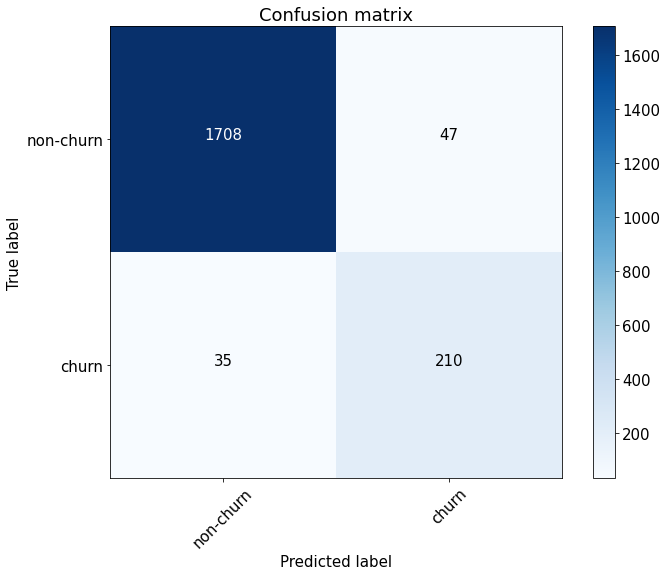

In [52]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non-churn', 'churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [53]:
roc_auc_score(y_test, preds)

0.9843502529216814

In [54]:
metrics_lda_mean_embedding = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]

## Задание 2

Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [55]:
def get_user_embedding(user_articles_list):
    '''
    The function receives a list of articles' ids a user read - '[323329, 321961, 324743, 323186, 324632, 474690]'.
    It converts it into a list. After this list is converted into an array of arrays of articles' probabilities.
    After, the array of arrays is transformed into the array of mean values of probabilities.
    '''
    user_articles_list = eval(user_articles_list)  # converting string into list
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])  # creation of array of arrays
    user_vector = np.median(user_vector, axis=0)  # creation of array of collumns' medians
    return user_vector

In [56]:
# array_1 = np.array([1, 2, 3])
# array_2 = np.array([4, 5, 6])
# array_3 = np.array([2, 3, 2])
# resulting_array = np.array([array_1, array_2, array_3])
# print(resulting_array)
# print(np.median(resulting_array, axis=0))

In [57]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings.head(2)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_90,topic_91,topic_92,topic_93,topic_94,topic_95,topic_96,topic_97,topic_98,topic_99
0,u105138,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.033755,0.0,0.0,0.011471,0.0
1,u108690,0.0,0.0,0.0,0.0,0.0,0.0,0.050124,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.041416,0.0,0.0,0.025662,0.0


In [58]:
target = pd.read_csv("lesson_2_profiling_user_LDA/users_churn.csv")

In [59]:
X = pd.merge(user_embeddings, target, 'left')

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [61]:
logreg = LogisticRegression()

In [62]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [63]:
preds = logreg.predict_proba(X_test)[:, 1]

In [64]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, \
                            precision_recall_curve, confusion_matrix

In [65]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f-score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.275469, F-Score=0.870, Precision=0.866, Recall=0.873


Confusion matrix, without normalization
[[1722   33]
 [  32  213]]


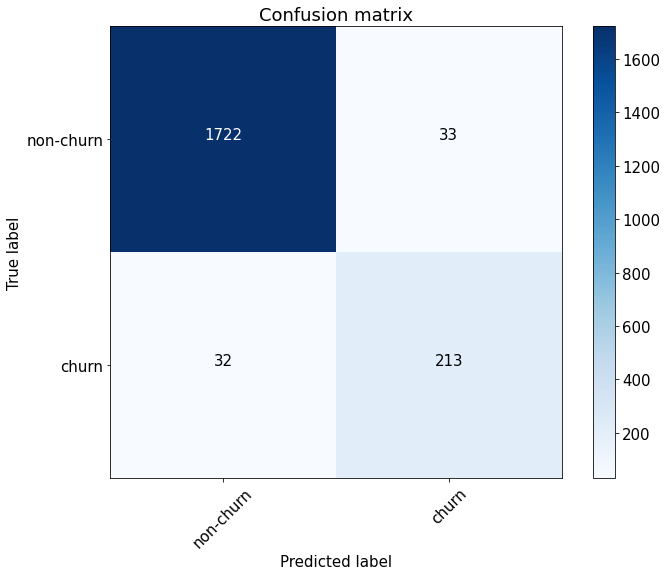

In [66]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non-churn', 'churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [67]:
roc_auc_score(y_test, preds)

0.9922344322344322

In [68]:
metrics_lda_median_embedding = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]

## Задание 3

Повторить п.2, но используя уже не медиану, а max

In [69]:
def get_user_embedding(user_articles_list):
    '''
    The function receives a list of articles' ids a user read - '[323329, 321961, 324743, 323186, 324632, 474690]'.
    It converts it into a list. After this list is converted into an array of arrays of articles' probabilities.
    After, the array of arrays is transformed into the array of mean values of probabilities.
    '''
    user_articles_list = eval(user_articles_list)  # converting string into list
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])  # creation of array of arrays
    user_vector = np.max(user_vector, axis=0)  # creation of array of collumns' maxs
    return user_vector

In [70]:
# array_1 = np.array([1, 2, 3])
# array_2 = np.array([4, 5, 6])
# array_3 = np.array([2, 3, 2])
# resulting_array = np.array([array_1, array_2, array_3])
# print(resulting_array)
# print(np.max(resulting_array, axis=0))

In [71]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings.head(2)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_90,topic_91,topic_92,topic_93,topic_94,topic_95,topic_96,topic_97,topic_98,topic_99
0,u105138,0.000000,0.0,0.0,0.029994,0.070573,0.075383,0.214283,0.026582,0.063312,...,0.0,0.02383,0.026579,0.051569,0.026989,0.106288,0.000000,0.023284,0.083788,0.0
1,u108690,0.083141,0.0,0.0,0.000000,0.090656,0.012867,0.116760,0.012422,0.000000,...,0.0,0.00000,0.012428,0.000000,0.027469,0.173400,0.019776,0.016603,0.135950,0.0


In [72]:
target = pd.read_csv("lesson_2_profiling_user_LDA/users_churn.csv")

In [73]:
X = pd.merge(user_embeddings, target, 'left')

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [75]:
logreg = LogisticRegression()

In [76]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [77]:
preds = logreg.predict_proba(X_test)[:, 1]

In [78]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, \
                            precision_recall_curve, confusion_matrix

In [79]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f-score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.359268, F-Score=0.938, Precision=0.925, Recall=0.951


Confusion matrix, without normalization
[[1736   19]
 [  13  232]]


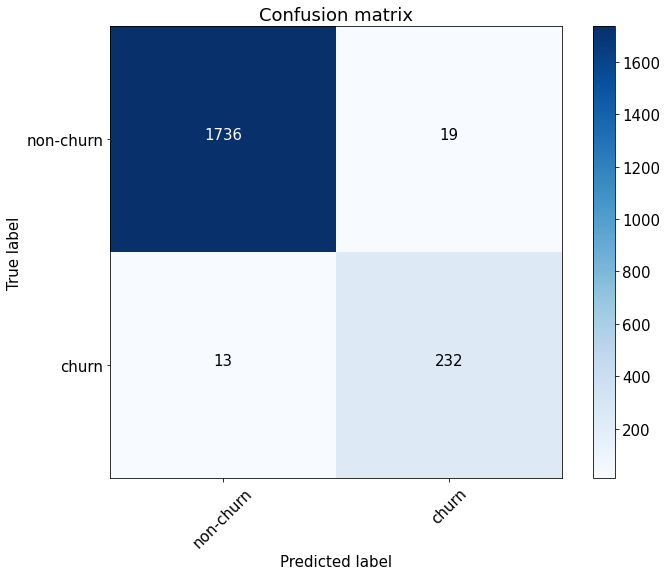

In [80]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non-churn', 'churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [81]:
roc_auc_score(y_test, preds)

0.9970719227862085

In [82]:
metrics_lda_max_embedding = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]

### Задание 4 (опциональное) 

Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

# as it was expected - right answer

# LDA approach + weighting of IDFs of articles and multiplication of those weights on their LDA vectors while calculating users' vectors

### getting IDFs of articles

In [83]:
users_ = users.copy()

In [84]:
users_['articles'].head(2)

0    [293672, 293328, 293001, 293622, 293126, 1852]
1            [3405, 1739, 2972, 1158, 1599, 322665]
Name: articles, dtype: object

In [85]:
users_['articles'] = users_['articles'].apply(lambda x: x.strip('[]').replace(',', ''))
users_['articles'].head(2)

0    293672 293328 293001 293622 293126 1852
1            3405 1739 2972 1158 1599 322665
Name: articles, dtype: object

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [87]:
tfidf = TfidfVectorizer()
tfidf.fit(users['articles'])

TfidfVectorizer()

In [88]:
ids_of_articles_list = [int(_) for _ in tfidf.get_feature_names_out()]
ids_of_articles_list[:10]

[10, 100, 1000, 1001, 1002, 1003, 1005, 1006, 1007, 1008]

In [89]:
idfs_of_articles = tfidf.idf_
idfs_of_articles[:10]

array([8.88870952, 7.90788027, 8.04141166, 8.88870952, 8.88870952,
       8.04141166, 8.60102745, 9.29417463, 9.29417463, 9.29417463])

In [90]:
len(ids_of_articles_list) == len(idfs_of_articles)

True

In [91]:
idf_dict = dict(zip(ids_of_articles_list, idfs_of_articles))
# idf_dict

In [92]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topic)]].values))

### creation of users' vectors; np.mean is used in embedding

In [93]:
def get_user_embedding(user_articles_list):
    '''
    The function receives a list of articles' ids a user read - '[323329, 321961, 324743, 323186, 324632, 474690]'.
    It converts it into a list. After this list is converted into an array of arrays of articles' probabilities.
    After, the array of arrays is transformed into the array of mean values of probabilities.
    '''
    user_articles_list = eval(user_articles_list)  # converting string into list
    user_vector = np.array([doc_dict[doc_id] * idf_dict[doc_id] for doc_id in user_articles_list if doc_id in idf_dict])  
                                                                                            # creation of array of arrays
    user_vector = np.mean(user_vector, axis=0)  # creation of array of collumns' maxs
    return user_vector

In [94]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings.head(2)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_90,topic_91,topic_92,topic_93,topic_94,topic_95,topic_96,topic_97,topic_98,topic_99
0,u105138,0.000000,0.0,0.0,0.046462,0.190434,0.102967,0.378445,0.038105,0.172319,...,0.0,0.036913,0.038101,0.07044,0.038688,0.351258,0.000000,0.047856,0.231193,0.0
1,u108690,0.193787,0.0,0.0,0.000000,0.154582,0.016706,0.469116,0.017806,0.000000,...,0.0,0.000000,0.016975,0.00000,0.037521,0.445936,0.029297,0.024597,0.397225,0.0


### prediction model and test

In [95]:
target = pd.read_csv("lesson_2_profiling_user_LDA/users_churn.csv")

In [96]:
X = pd.merge(user_embeddings, target, 'left')

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [98]:
logreg = LogisticRegression()

In [99]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [100]:
preds = logreg.predict_proba(X_test)[:, 1]

In [101]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, \
                            precision_recall_curve, confusion_matrix

In [102]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f-score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.436821, F-Score=0.916, Precision=0.901, Recall=0.931


Confusion matrix, without normalization
[[1730   25]
 [  18  227]]


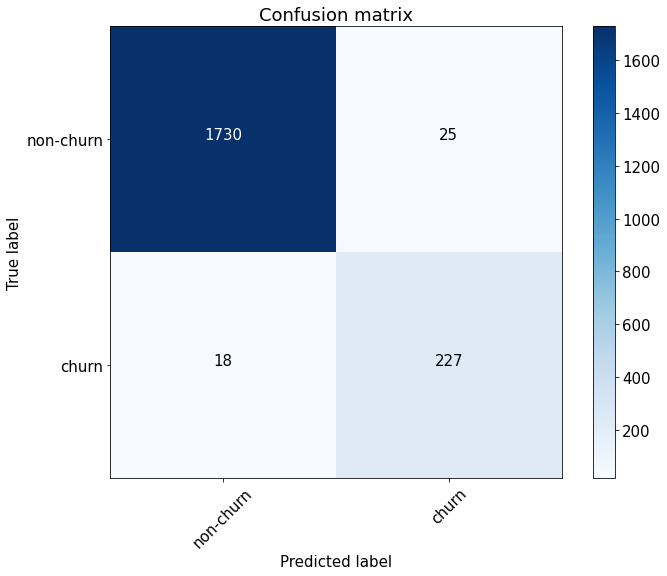

In [103]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non-churn', 'churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [104]:
roc_auc_score(y_test, preds)

0.9954881097738241

In [105]:
metrics_lda_idf_mean_embedding = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]

# my version (initial, there is an improved one)!!!

# creation of a user's vector through calculation of the mean of TF-IDF vectors of articles a user read; LDA is not used

In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer

### TfidfVectorizer initialization

In [107]:
N_features=100
tf = TfidfVectorizer(stop_words=stopword_ru, max_features=N_features)

In [108]:
news_ = news.copy()  # precautions measures
news_

,doc_id,title
0,6,"[заместитель, председатель, правительство, рф,..."
1,4896,"[матч, финал, кубок, россия, футбол, приостано..."
2,4897,"[форвард, авангард, томаш, заборский, прокомме..."
3,4898,"[главный, тренер, кубань, юрий, красножанин, п..."
4,4899,"[решение, попечительский, совет, владивостокск..."
...,...,...
26995,513441,"[учёный, токийский, университет, морской, наук..."
26996,513442,"[глава, кафедра, отечественный, история, xx, в..."
26997,513443,"[американский, учёный, уточнить, возраст, расп..."
26998,513444,"[последний, тропический, углеродный, цикл, чув..."


### changing datatype of news_['title'] from list to string

In [109]:
news_['title'] = news_['title'].apply(lambda x: clean_text(str(x)))

In [110]:
news_['title']

0        заместитель председатель правительство рф серг...
1        матч финал кубок россия футбол приостановить с...
2        форвард авангард томаш заборский прокомментиро...
3        главный тренер кубань юрий красножанин прокомм...
4        решение попечительский совет владивостокский с...
                               ...                        
26995    учёный токийский университет морской наука тех...
26996    глава кафедра отечественный история xx век ист...
26997    американский учёный уточнить возраст расположи...
26998    последний тропический углеродный цикл чувствит...
26999    жить примерно тыс назад территория современный...
Name: title, Length: 27000, dtype: object

### creation of sparse matrix with tf.fit_transform

In [111]:
tfidf_articles = tf.fit_transform(news_['title'])
tfidf_articles

C:\Users\fross\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['_ссылка', 'всё', 'интерфакс', 'как_сообщили_риа_', 'новости', 'передает_риа_', 'сообщает_', 'сообщает_риа_'] not in stop_words.
  warnings.warn(


<27000x100 sparse matrix of type '<class 'numpy.float64'>'
	with 463980 stored elements in Compressed Sparse Row format>

In [112]:
tfidf_matrix = pd.DataFrame.sparse.from_spmatrix(tfidf_articles, columns=sorted(tf.vocabulary_))
tfidf_matrix.columns = ['word_{}'.format(i) for i in range(N_features)]  # changing names of columns from real words 
                                                                         # to word_0, word_1, word_2...
tfidf_matrix.head(2)

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,...,word_90,word_91,word_92,word_93,word_94,word_95,word_96,word_97,word_98,word_99
0,0.564466,0.000000,0.0,0.255722,0.0,0.0,0.0,0.0,0.177648,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.697328,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### adding to tfidf_matrix 'doc_id' column

In [113]:
tfidf_matrix['doc_id'] = news_['doc_id'].values
tfidf_matrix.head(2)

C:\Users\fross\AppData\Local\Temp/ipykernel_4596/3738657765.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  tfidf_matrix['doc_id'] = news_['doc_id'].values


,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,...,word_91,word_92,word_93,word_94,word_95,word_96,word_97,word_98,word_99,doc_id
0,0.564466,0.000000,0.0,0.255722,0.0,0.0,0.0,0.0,0.177648,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1,0.000000,0.697328,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4896


### transformation of tfidf_matrix into a dictionary

In [114]:
doc_dict = dict(zip(tfidf_matrix['doc_id'].values, tfidf_matrix[['word_{}'.format(i) for i in range(N_features)]].values))

### creation of users' vectors; np.mean is used in embedding

In [115]:
def get_user_embedding(user_articles_list):
    '''
    The function receives a list of articles' ids a user read - '[323329, 321961, 324743, 323186, 324632, 474690]'.
    It converts it into a list. After this list is converted into an array of arrays of articles' probabilities.
    After, the array of arrays is transformed into the array of mean values of probabilities.
    '''
    user_articles_list = eval(user_articles_list)  # converting string into list
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])  # creation of array of arrays
    user_vector = np.mean(user_vector, axis=0)  # creation of array of collumns' maxs
    return user_vector

In [116]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['word_{}'.format(i) for i in range(N_features)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['word_{}'.format(i) for i in range(N_features)]]
user_embeddings.head(2)

,uid,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,...,word_90,word_91,word_92,word_93,word_94,word_95,word_96,word_97,word_98,word_99
0,u105138,0.170270,0.035110,0.125729,0.0,0.078510,0.000000,0.000000,0.066400,0.064866,...,0.0,0.110193,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
1,u108690,0.048984,0.008298,0.030378,0.0,0.060469,0.031747,0.050475,0.026896,0.046313,...,0.0,0.328820,0.091238,0.035267,0.010589,0.0,0.0,0.039674,0.021024,0.021627


### prediction model and test

In [117]:
target = pd.read_csv("lesson_2_profiling_user_LDA/users_churn.csv")

In [118]:
X = pd.merge(user_embeddings, target, 'left')

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X[['word_{}'.format(i) for i in range(N_features)]], 
                                                    X['churn'], random_state=0)

In [120]:
logreg = LogisticRegression()

In [121]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [122]:
preds = logreg.predict_proba(X_test)[:, 1]

In [123]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, \
                            precision_recall_curve, confusion_matrix

In [124]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f-score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.296801, F-Score=0.984, Precision=0.976, Recall=0.992


Confusion matrix, without normalization
[[1749    6]
 [   3  242]]


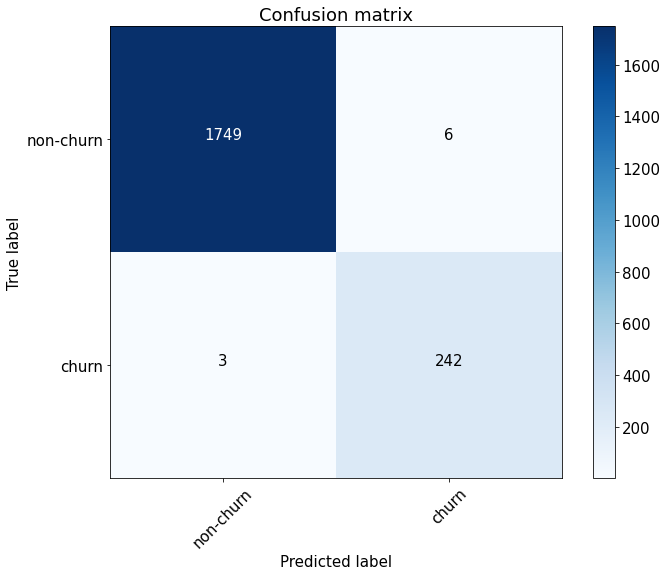

In [125]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non-churn', 'churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [126]:
roc_auc_score(y_test, preds)

0.9998558055700912

In [127]:
metrics_tfidf_mean_embedding = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]

# my improved version!!!

# creation of a user's vector through calculation of the mean of TF-IDF vectors of articles a user read + weighting of IDFs of those articles and multiplication of those weights on their TF-IDF vectors while calculating users' vectors; LDA is not used

In [128]:
users_ = users.copy()

In [129]:
users_['articles'].head(2)

0    [293672, 293328, 293001, 293622, 293126, 1852]
1            [3405, 1739, 2972, 1158, 1599, 322665]
Name: articles, dtype: object

In [130]:
users_['articles'] = users_['articles'].apply(lambda x: x.strip('[]').replace(',', ''))
users_['articles'].head(2)

0    293672 293328 293001 293622 293126 1852
1            3405 1739 2972 1158 1599 322665
Name: articles, dtype: object

In [131]:
tfidf = TfidfVectorizer()
tfidf.fit(users['articles'])

TfidfVectorizer()

In [132]:
ids_of_articles_list = [int(_) for _ in tfidf.get_feature_names_out()]
ids_of_articles_list[:10]

[10, 100, 1000, 1001, 1002, 1003, 1005, 1006, 1007, 1008]

In [133]:
idfs_of_articles = tfidf.idf_
idfs_of_articles[:10]

array([8.88870952, 7.90788027, 8.04141166, 8.88870952, 8.88870952,
       8.04141166, 8.60102745, 9.29417463, 9.29417463, 9.29417463])

In [134]:
len(ids_of_articles_list) == len(idfs_of_articles)

True

In [135]:
idf_dict = dict(zip(ids_of_articles_list, idfs_of_articles))
# idf_dict

### TfidfVectorizer initialization

In [136]:
N_features=100
tf = TfidfVectorizer(stop_words=stopword_ru, max_features=N_features)

In [137]:
news_ = news.copy()  # precautions measures

### changing datatype of news_['title'] from list to string

In [138]:
news_['title'] = news_['title'].apply(lambda x: clean_text(str(x)))

In [139]:
news_['title']

0        заместитель председатель правительство рф серг...
1        матч финал кубок россия футбол приостановить с...
2        форвард авангард томаш заборский прокомментиро...
3        главный тренер кубань юрий красножанин прокомм...
4        решение попечительский совет владивостокский с...
                               ...                        
26995    учёный токийский университет морской наука тех...
26996    глава кафедра отечественный история xx век ист...
26997    американский учёный уточнить возраст расположи...
26998    последний тропический углеродный цикл чувствит...
26999    жить примерно тыс назад территория современный...
Name: title, Length: 27000, dtype: object

### creation of sparse matrix with tf.fit_transform

In [140]:
tfidf_articles = tf.fit_transform(news_['title'])
tfidf_articles

C:\Users\fross\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['_ссылка', 'всё', 'интерфакс', 'как_сообщили_риа_', 'новости', 'передает_риа_', 'сообщает_', 'сообщает_риа_'] not in stop_words.
  warnings.warn(


<27000x100 sparse matrix of type '<class 'numpy.float64'>'
	with 463980 stored elements in Compressed Sparse Row format>

In [141]:
tfidf_matrix = pd.DataFrame.sparse.from_spmatrix(tfidf_articles, columns=sorted(tf.vocabulary_))
tfidf_matrix.columns = ['word_{}'.format(i) for i in range(N_features)]  # changing names of columns from real words 
                                                                         # to word_0, word_1, word_2...
tfidf_matrix.head(2)

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,...,word_90,word_91,word_92,word_93,word_94,word_95,word_96,word_97,word_98,word_99
0,0.564466,0.000000,0.0,0.255722,0.0,0.0,0.0,0.0,0.177648,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.697328,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### adding to tfidf_matrix 'doc_id' column

In [142]:
tfidf_matrix['doc_id'] = news_['doc_id'].values
tfidf_matrix.head(2)

C:\Users\fross\AppData\Local\Temp/ipykernel_4596/3738657765.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  tfidf_matrix['doc_id'] = news_['doc_id'].values


,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,...,word_91,word_92,word_93,word_94,word_95,word_96,word_97,word_98,word_99,doc_id
0,0.564466,0.000000,0.0,0.255722,0.0,0.0,0.0,0.0,0.177648,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1,0.000000,0.697328,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4896


### transformation of tfidf_matrix into a dictionary

In [143]:
doc_dict = dict(zip(tfidf_matrix['doc_id'].values, tfidf_matrix[['word_{}'.format(i) for i in range(N_features)]].values))

### creation of users' vectors; np.mean is used in embedding

In [144]:
def get_user_embedding(user_articles_list):
    '''
    The function receives a list of articles' ids a user read - '[323329, 321961, 324743, 323186, 324632, 474690]'.
    It converts it into a list. After this list is converted into an array of arrays of articles' probabilities.
    After, the array of arrays is transformed into the array of mean values of probabilities.
    '''
    user_articles_list = eval(user_articles_list)  # converting string into list
#     user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])  # creation of array of arrays
    user_vector = np.array([doc_dict[doc_id] * idf_dict[doc_id] for doc_id in user_articles_list if doc_id in idf_dict]) 
    user_vector = np.mean(user_vector, axis=0)  # creation of array of collumns' maxs
    return user_vector

In [145]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['word_{}'.format(i) for i in range(N_features)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['word_{}'.format(i) for i in range(N_features)]]
user_embeddings.head(2)

,uid,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,...,word_90,word_91,word_92,word_93,word_94,word_95,word_96,word_97,word_98,word_99
0,u105138,1.485463,0.301986,1.030418,0.0,0.675263,0.000000,0.000000,0.604884,0.590911,...,0.0,0.947773,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
1,u108690,0.406232,0.077124,0.270021,0.0,0.493104,0.282189,0.429644,0.245841,0.421590,...,0.0,2.972486,0.829185,0.294348,0.094126,0.0,0.0,0.359531,0.186878,0.184691


### prediction model and test

In [146]:
target = pd.read_csv("lesson_2_profiling_user_LDA/users_churn.csv")

In [147]:
X = pd.merge(user_embeddings, target, 'left')

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X[['word_{}'.format(i) for i in range(N_features)]], 
                                                    X['churn'], random_state=0)

In [149]:
logreg = LogisticRegression()

In [150]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [151]:
preds = logreg.predict_proba(X_test)[:, 1]

In [152]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, \
                            precision_recall_curve, confusion_matrix

In [153]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f-score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.489742, F-Score=0.996, Precision=0.992, Recall=1.000


Confusion matrix, without normalization
[[1753    2]
 [   1  244]]


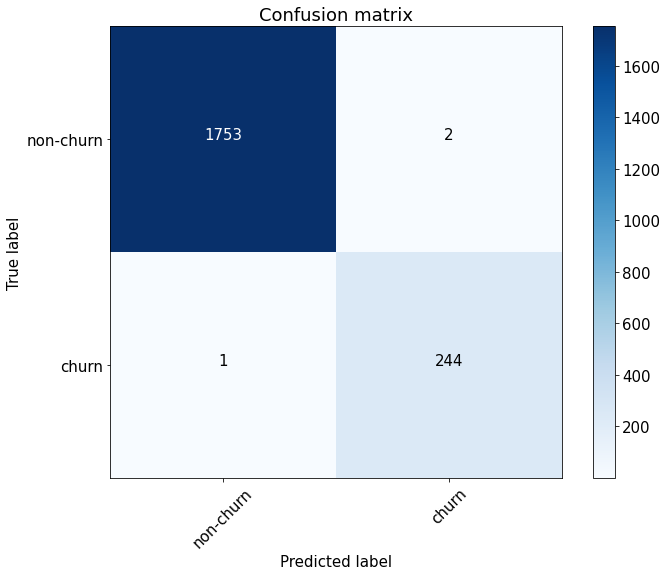

In [154]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non-churn', 'churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [155]:
roc_auc_score(y_test, preds)

0.9999651142508286

In [156]:
metrics_tfidf_and_idf_mean_embedding = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]

### Задание 5

Сформировать на выходе единую таблицу, сравнивающую качество 4 разных методов получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

### table of metrics

In [157]:
pd.DataFrame({
    'metrics_lda_mean_embedding': metrics_lda_mean_embedding,
    'metrics_lda_median_embedding': metrics_lda_median_embedding,
    'metrics_lda_max_embedding': metrics_lda_max_embedding,
    'metrics_lda_idf_mean_embedding': metrics_lda_idf_mean_embedding,
    'metrics_tfidf_mean_embedding': metrics_tfidf_mean_embedding,  # the way I invented it!!!
    'metrics_tfidf_and_idf_mean_embedding': metrics_tfidf_and_idf_mean_embedding  # the way I improved it!!!
}, index=['fscore', 'precision', 'recall', 'roc_auc_score']).transpose()

,fscore,precision,recall,roc_auc_score
metrics_lda_mean_embedding,0.838966,0.817829,0.861224,0.984350
metrics_lda_median_embedding,0.869919,0.866397,0.873469,0.992234
metrics_lda_max_embedding,0.937626,0.924603,0.951020,0.997072
metrics_lda_idf_mean_embedding,0.915663,0.901186,0.930612,0.995488
metrics_tfidf_mean_embedding,0.983806,0.975904,0.991837,0.999856
metrics_tfidf_and_idf_mean_embedding,0.995935,0.991903,1.000000,0.999965


### Задание 6

Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

1. Подход со взвешиванием статей по IDF в дополнение к LDA подходу (fscore=0.915663) не улучшил метрику по сравнению с np.max.
2. TF-IDF подход моей разработки показал себя практически идеально по метрикам (fscore=0.983806), чем всё остальное, даже при равном количестве признаков с LDA подходом (100 в TF-IDF и 100 в LDA при 20 проходах).
3. Добавление к моему TF-IDF подходу взвешивания статей по IDF показало __fscore=0.995935!!!__ (и __до 1__ при классификации по 300 словам!!!)
3. Добавление гиперпараметра passes=20 при инициализации LdaModel (LDA подход) существенно улучшило метрики по сравнению с passes=1 по дефолту.
4. embedding-и с np.mean и np.median в LDA подходе дали метрики слабее, чем с np.max. Скорее всего, np.max делает более 'выразительные' координаты объектов пользователей в пространстве признаков, тем самым помогая сформировать более лучшую разделяющую гиперплоскость.

PS: было очень интересно!